# 基于PyTorch的transformer情感分析项目

### 验证版本

In [1]:
import torch
import transformers

print("Torch:", torch.__version__)
print("Transformers:", transformers.__version__)
print("MPS available:", torch.backends.mps.is_available())

Torch: 2.7.0
Transformers: 4.40.0
MPS available: True


### -------------------------------------------------------------
### 阶段一：导入库和工具函数
### -------------------------------------------------------------

In [2]:
# 1. 导入必要的库
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
# from collections import Counter # 不再需要
import matplotlib.pyplot as plt
import numpy as np
import os # 用于文件路径操作

# Hugging Face Transformers 库
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from transformers import get_scheduler

# 导入之前的通用工具函数
import sys
# 假设 Notebook 路径是 pytorch_imdb_sentiment_analysis/notebooks/
# 所以回到项目根目录是 '..'
sys.path.append('..') 
from utils.train_eval_utils import set_seed
# 不需要直接导入 train_model, evaluate_model, save_model, load_model，因为我们将在Notebook中直接编写训练评估循环。
# 这样更灵活，避免 train_eval_utils.py 依赖HuggingFace的特定输出格式。

# 导入文本预处理工具
from utils.text_preprocessing import load_imdb_data, clean_text # 导入这两个函数

In [3]:
# 2. 设备设置
if torch.backends.mps.is_available():
    device = torch.device("mps")
    print("Using MPS device for training.")
else:
    device = torch.device("cpu")
    print("MPS device not available, using CPU for training.")

# 3. 设置随机种子
SEED = 66
set_seed(SEED)

Using MPS device for training.
Random seed set to 66


### -------------------------------------------------------------
### 阶段二：构建数据集和加载数据
### -------------------------------------------------------------

In [4]:
# 4. 文本数据加载与预处理 (使用真实的 IMDB 数据集，手动加载和清洗)

# 定义 IMDB 数据集路径
# ***重要：请确保你已经手动下载并解压 IMDB 数据集到这个路径下***
# 下载链接：http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
# 解压后，你的 data/ 目录下应该有 aclImdb/ 文件夹
IMDB_ROOT_DIR = '../data/aclImdb' # 确保你的 aclImdb 文件夹在这个路径下

# 加载真实的 IMDB 训练数据
print("Loading real IMDB training data...")
# train/pos 和 train/neg 才是实际数据
raw_train_data = load_imdb_data(os.path.join(IMDB_ROOT_DIR, 'train')) 
print("Cleaning training data (this may take a moment)...")
cleaned_train_data = []
for label, text in raw_train_data:
    cleaned_train_data.append((label, clean_text(text)))

# 加载真实的 IMDB 测试数据
print("Loading real IMDB testing data...")
# test/pos 和 test/neg 才是实际数据
raw_test_data = load_imdb_data(os.path.join(IMDB_ROOT_DIR, 'test'))
print("Cleaning testing data (this may take a moment)...")
cleaned_test_data = []
for label, text in raw_test_data:
    cleaned_test_data.append((label, clean_text(text)))

# 打印加载的数据量，确认是否正确
print(f"Loaded {len(cleaned_train_data)} training samples.")
print(f"Loaded {len(cleaned_test_data)} testing samples.")
print(f"Example cleaned positive review (first 100 chars): {cleaned_train_data[0][1][:100]}...")
print(f"Example cleaned negative review (first 100 chars): {cleaned_train_data[len(cleaned_train_data)//2][1][:100]}...") # 打印一个负面评论示例

# 定义自定义 Dataset 类，用于将加载的 (label, text) 对转换为 BERT 输入
class IMDBDatasetWithBERT(Dataset):
    def __init__(self, data, tokenizer, max_len): # 接收已加载和清洗后的数据
        self.tokenizer = tokenizer
        self.max_len = max_len
        self.texts = [item[1] for item in data]
        self.labels = [item[0] for item in data] # 标签已经是0或1

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]

# 使用 BERT 分词器进行编码
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length', 
            return_attention_mask=True,
            return_tensors='pt',
            truncation=True
        )
        
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }
    # 返回模型输入格式
# 加载预训练的 BERT tokenizer，12 层 Transformer，768 hidden size，12 attention heads；不区分大小写
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# 定义最大序列长度 (BERT 通常限制为 512)
MAX_LEN = 256 # 对于电影评论，256 可能更合理，确保能捕捉更多信息。可根据内存调整

# 创建数据集实例 (使用清洗后的真实数据)
train_dataset = IMDBDatasetWithBERT(cleaned_train_data, tokenizer, MAX_LEN)
test_dataset = IMDBDatasetWithBERT(cleaned_test_data, tokenizer, MAX_LEN)

print(f"\nCreated {len(train_dataset)} training dataset samples.")
print(f"Created {len(test_dataset)} testing dataset samples.")

# 创建 DataLoader
batch_size = 16 # BERT 通常使用 16 或 32 的批次大小，因为模型较大
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

# 示例：获取一个批次数据
for batch in train_dataloader:
    input_ids = batch['input_ids']
    attention_mask = batch['attention_mask']
    labels = batch['labels']

    print(f"\nInput IDs batch shape: {input_ids.shape}")
    print(f"Attention Mask batch shape: {attention_mask.shape}")
    print(f"Labels batch shape: {labels.shape}")

    # 打印第一个样本的解码文本 (只解码前一部分，因为MAX_LEN可能很长)
    print(f"\nOriginal text (first sample, truncated to 100 chars): {cleaned_train_data[batch['labels'][0]][1][:100]}...") # 对应原始加载的文本
    print(f"Decoded text (first sample, first 10 tokens): {tokenizer.decode(input_ids[0, :10])}")
    break

Loading real IMDB training data...
Cleaning training data (this may take a moment)...
Loading real IMDB testing data...
Cleaning testing data (this may take a moment)...
Loaded 25000 training samples.
Loaded 25000 testing samples.
Example cleaned positive review (first 100 chars): for a movie that gets no respect there sure are a lot of memorable quotes listed for this gem imagin...
Example cleaned negative review (first 100 chars): working with one of the best shakespeare sources this film manages to be creditable to its source wh...


/opt/miniconda3/envs/pytorch_env_1/lib/python3.10/site-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(



Created 25000 training dataset samples.
Created 25000 testing dataset samples.

Input IDs batch shape: torch.Size([16, 256])
Attention Mask batch shape: torch.Size([16, 256])
Labels batch shape: torch.Size([16])

Original text (first sample, truncated to 100 chars): for a movie that gets no respect there sure are a lot of memorable quotes listed for this gem imagin...
Decoded text (first sample, first 10 tokens): [CLS] dietrich bonhoeffers writings have had a



### -------------------------------------------------------------
### 阶段三：构建和微调 Transformer 模型 (BertForSequenceClassification)
### -------------------------------------------------------------

In [5]:
# 1. 模型实例化
# num_labels 应该与你的分类任务的类别数匹配 (IMDB是二分类: 正面/负面)
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)
model = model.to(device)

print("\nBERT Model Structure (truncated for brevity):")
# 由于BERT模型结构非常复杂，这里只打印其顶部几层
print(model.bert.embeddings)
print(model.classifier)


# 2. 定义优化器和学习率调度器
# AdamW 是针对 Transformer 模型推荐的优化器，它修正了 Adam 中的权重衰减
optimizer = AdamW(model.parameters(), lr=1e-5) # 预训练模型微调的推荐学习率通常在 1e-5 到 5e-5 之间

# 学习率调度器 (Hugging Face 提供了专为 Transformer 设计的调度器)
# Get the number of training steps
total_steps = len(train_dataloader) * 3 # 假设我们先训练 3 个 Epoch
warmup_steps = 0 # 可以设置一个预热步数，让学习率从0开始逐渐上升
scheduler = get_scheduler(
    "linear", # 或 "cosine"
    optimizer=optimizer,
    num_warmup_steps=warmup_steps,
    num_training_steps=total_steps
)

/opt/miniconda3/envs/pytorch_env_1/lib/python3.10/site-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



BERT Model Structure (truncated for brevity):
BertEmbeddings(
  (word_embeddings): Embedding(30522, 768, padding_idx=0)
  (position_embeddings): Embedding(512, 768)
  (token_type_embeddings): Embedding(2, 768)
  (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
  (dropout): Dropout(p=0.1, inplace=False)
)
Linear(in_features=768, out_features=2, bias=True)


/opt/miniconda3/envs/pytorch_env_1/lib/python3.10/site-packages/transformers/optimization.py:521: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


### -------------------------------------------------------------
### 阶段四：训练循环 (需要适配 Hugging Face 模型输出)
### -------------------------------------------------------------

### 这里我们将直接在 Notebook 中编写训练和评估循环，因为需要适配 Hugging Face 模型的特殊输出。
### 以后可以考虑将其封装到 train_eval_utils.py 中，但现在直接写更清晰。

In [6]:
num_epochs_bert = 3 # 预训练模型通常 2-4 个 Epoch 就能达到好效果

print("\n--- Starting BERT Fine-tuning ---")

for epoch in range(num_epochs_bert):
    model.train()
    total_loss = 0
    correct_predictions = 0
    total_samples = 0

    for batch_idx, batch in enumerate(train_dataloader):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        optimizer.zero_grad()

        # Hugging Face 模型的前向传播
        # 返回一个字典，其中包含 loss 和 logits
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        logits = outputs.logits # Logits 用于计算准确率

        total_loss += loss.item()

        loss.backward()
        optimizer.step()
        scheduler.step() # 学习率调度器更新

        # 计算训练准确率
        _, predicted = torch.max(logits, dim=1)
        correct_predictions += (predicted == labels).sum().item()
        total_samples += labels.size(0)

        if batch_idx % 100 == 0: # 每 100 个批次打印一次进度
            print(f"  Epoch {epoch+1}, Batch {batch_idx}/{len(train_dataloader)}, Loss: {loss.item():.4f}")

    avg_train_loss = total_loss / len(train_dataloader)
    train_accuracy = correct_predictions / total_samples * 100
    print(f"Epoch {epoch+1} completed. Avg Train Loss: {avg_train_loss:.4f}, Train Acc: {train_accuracy:.2f}%")


print("--- BERT Fine-tuning Finished ---")



--- Starting BERT Fine-tuning ---
  Epoch 1, Batch 0/1563, Loss: 0.7480
  Epoch 1, Batch 100/1563, Loss: 0.2745
  Epoch 1, Batch 200/1563, Loss: 0.2554
  Epoch 1, Batch 300/1563, Loss: 0.3306
  Epoch 1, Batch 400/1563, Loss: 0.2770
  Epoch 1, Batch 500/1563, Loss: 0.2149
  Epoch 1, Batch 600/1563, Loss: 0.6557
  Epoch 1, Batch 700/1563, Loss: 0.1569
  Epoch 1, Batch 800/1563, Loss: 0.1047
  Epoch 1, Batch 900/1563, Loss: 0.3467
  Epoch 1, Batch 1000/1563, Loss: 0.6313
  Epoch 1, Batch 1100/1563, Loss: 0.2793
  Epoch 1, Batch 1200/1563, Loss: 0.3797
  Epoch 1, Batch 1300/1563, Loss: 0.1983
  Epoch 1, Batch 1400/1563, Loss: 0.2359
  Epoch 1, Batch 1500/1563, Loss: 0.1820
Epoch 1 completed. Avg Train Loss: 0.2700, Train Acc: 88.69%
  Epoch 2, Batch 0/1563, Loss: 0.0948
  Epoch 2, Batch 100/1563, Loss: 0.1315
  Epoch 2, Batch 200/1563, Loss: 0.0611
  Epoch 2, Batch 300/1563, Loss: 0.1016
  Epoch 2, Batch 400/1563, Loss: 0.0585
  Epoch 2, Batch 500/1563, Loss: 0.0655
  Epoch 2, Batch 600/1

### -------------------------------------------------------------
### 阶段五：模型评估
### -------------------------------------------------------------


--- Starting BERT Evaluation with Comprehensive Metrics ---
Evaluation completed. Avg Test Loss: 0.2293
Accuracy: 0.9210
Precision: 0.9183
Recall: 0.9241
F1-Score: 0.9212
--- BERT Evaluation Finished ---


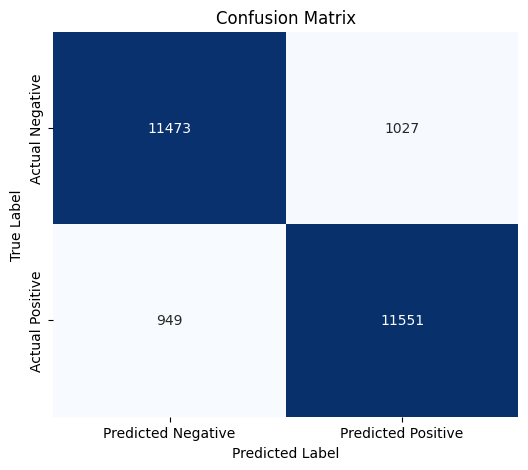

In [10]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
import seaborn as sns # 用于绘制混淆矩阵
import pandas as pd # 用于混淆矩阵的DataFrame

print("\n--- Starting BERT Evaluation with Comprehensive Metrics ---")
model.eval() 
all_labels = []
all_preds = []
total_eval_loss = 0

with torch.no_grad():
    for batch in test_dataloader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        logits = outputs.logits

        total_eval_loss += loss.item()

        _, predicted = torch.max(logits, dim=1)
        
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(predicted.cpu().numpy())

avg_eval_loss = total_eval_loss / len(test_dataloader)

# 计算各项指标
accuracy = accuracy_score(all_labels, all_preds)
# precision_recall_fscore_support 默认会为每个类别计算，这里需要指定 average 参数
# binary: 适用于二分类
# macro: 简单平均每个类别的指标
# weighted: 按每个类别样本数加权平均
precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average='binary', pos_label=1) # positive label is 1

print(f"Evaluation completed. Avg Test Loss: {avg_eval_loss:.4f}")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")
print("--- BERT Evaluation Finished ---")

# 绘制混淆矩阵
cm = confusion_matrix(all_labels, all_preds)
cm_df = pd.DataFrame(cm, index=['Actual Negative', 'Actual Positive'], columns=['Predicted Negative', 'Predicted Positive'])
# 打印 DataFrame 格式
print("\nConfusion Matrix (DataFrame):")
plt.figure(figsize=(6, 5))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()




### -------------------------------------------------------------
### 阶段六：模型保存与加载 (适配 Hugging Face 模型)
### -------------------------------------------------------------

### Hugging Face 模型的保存和加载与 torch.save 略有不同
### 推荐使用其自带的 save_pretrained 和 from_pretrained 方法

In [11]:
output_dir = '../model_checkpoints/bert_imdb_sentiment'
os.makedirs(output_dir, exist_ok=True)

print(f"\nSaving model to {output_dir}")
model.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir) # 也要保存分词器，因为它的词汇表和模型是配套的
print("Model saved.")

# 加载模型示例
print(f"\nLoading model from {output_dir}")
loaded_model = BertForSequenceClassification.from_pretrained(output_dir)
loaded_tokenizer = BertTokenizer.from_pretrained(output_dir)
loaded_model = loaded_model.to(device)
loaded_model.eval()

# 再次评估加载后的模型
loaded_all_labels = []
loaded_all_preds = []
loaded_total_eval_loss = 0
with torch.no_grad():
    for batch in test_dataloader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = loaded_model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        logits = outputs.logits

        loaded_total_eval_loss += loss.item()

        _, predicted = torch.max(logits, dim=1)
        
        loaded_all_labels.extend(labels.cpu().numpy())
        loaded_all_preds.extend(predicted.cpu().numpy())

loaded_avg_eval_loss = loaded_total_eval_loss / len(test_dataloader)
loaded_accuracy = accuracy_score(loaded_all_labels, loaded_all_preds)
loaded_precision, loaded_recall, loaded_f1, _ = precision_recall_fscore_support(loaded_all_labels, loaded_all_preds, average='binary', pos_label=1)

print(f"Loaded Model Evaluation. Avg Test Loss: {loaded_avg_eval_loss:.4f}")
print(f"Accuracy: {loaded_accuracy:.4f}")
print(f"Precision: {loaded_precision:.4f}")
print(f"Recall: {loaded_recall:.4f}")
print(f"F1-Score: {loaded_f1:.4f}")


Saving model to ../model_checkpoints/bert_imdb_sentiment
Model saved.

Loading model from ../model_checkpoints/bert_imdb_sentiment
Loaded Model Evaluation. Avg Test Loss: 0.2293
Accuracy: 0.9210
Precision: 0.9183
Recall: 0.9241
F1-Score: 0.9212
